In [1]:
import glob
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from model import data_analysis
from plotly.subplots import make_subplots

DATA_PATH = '../data/Data_20200731/'

In [9]:
#FILENAME = 'raw_NISTA001_20200715_024114_GMT.bin.marked.csv.csv'
#FILENAME =  'raw_NISTA052_20200716_193850_GMT.bin.marked.csv.csv'
FILENAME ='raw_NISTA051_20200716_192656_GMT.bin.marked.csv.csv'
# 'raw_NISTA021_20200716_213906_GMT.bin.marked.csv'
# # this data process above assumes a simple <60 dBm filter to set false positive
# 'raw_NISTA014_20200708_014055_GMT.bin.marked.csv.csv'
# 'raw_NISTA001_20200715_024114_GMT.bin.marked.csv.csv'

df = data_analysis.load_marked(os.path.join(DATA_PATH, FILENAME))
df.head()

,time,rssi,encounter_id,close encounter
0,2020-07-16 12:54:00,-71,f960a46ada175d32fd1e126bfabd7053b990c8bdb850a7...,STARTED LOGGING
1,2020-07-16 12:54:00,-76,edbe0ba3bf0b0033835a47e6c7432270218b5e7913be9f...,NaN
2,2020-07-16 12:54:00,-71,0b07b78a66040a3afc665719e58dadf7d804df63a8ad61...,NaN
3,2020-07-16 12:55:00,-69,f960a46ada175d32fd1e126bfabd7053b990c8bdb850a7...,NaN
4,2020-07-16 12:55:00,-75,edbe0ba3bf0b0033835a47e6c7432270218b5e7913be9f...,NaN


In [10]:
df['close encounter'][1]

nan

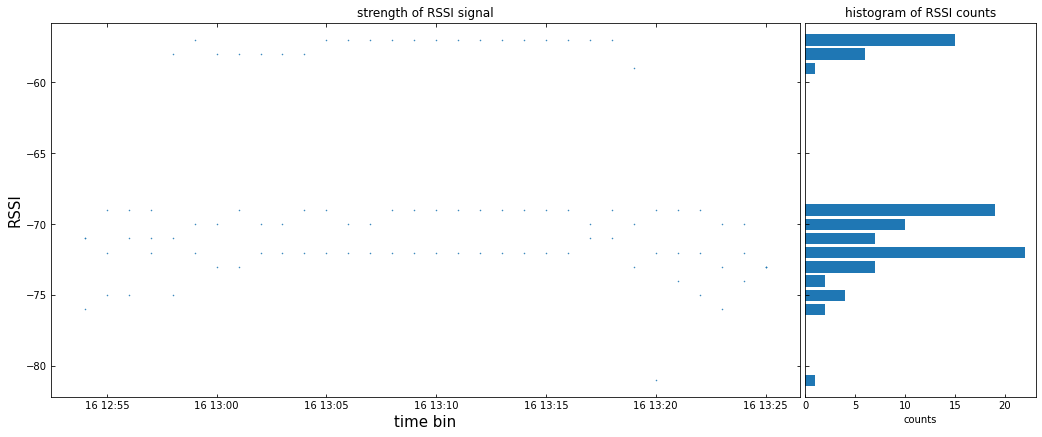

In [11]:
figure = data_analysis.plot_rssi(df['time'], df['rssi'])
# add axes labels
plt.show()

In [12]:
[unique_ids,unique_counts] = data_analysis.get_unique(df)
unique_ids

array(['0b07b78a66040a3afc665719e58dadf7d804df63a8ad61645efed1291fddae0e',
       'edbe0ba3bf0b0033835a47e6c7432270218b5e7913be9f7be1f9f58fad8cda67',
       'f960a46ada175d32fd1e126bfabd7053b990c8bdb850a75ad471910b6d901852'],
      dtype=object)

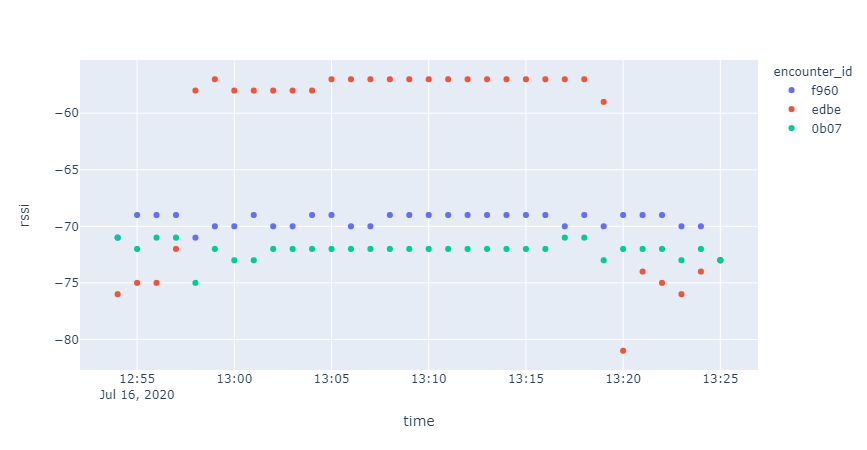

In [13]:
figure = data_analysis.plot_data_check(df)
figure.show()

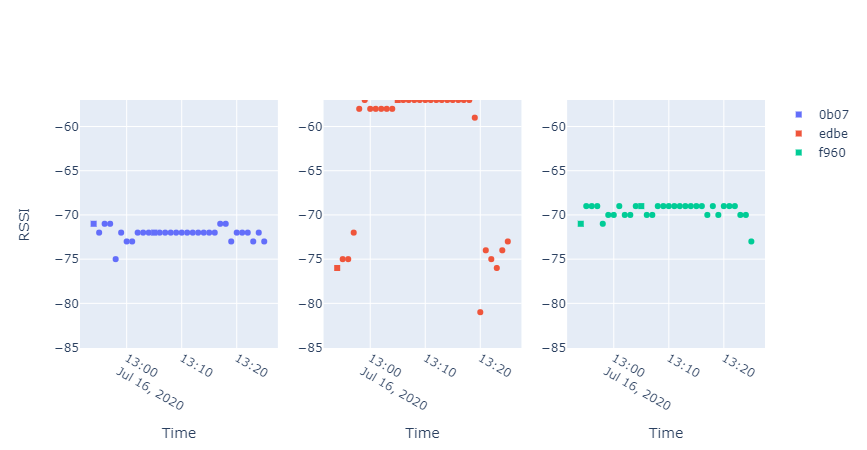

In [14]:
WINDOW_SIZE = 6
REQD_READINGS = 4
CLOSE_LEVEL = -50
# default value is -60

fig = make_subplots(rows=1, cols=len(unique_ids[unique_counts>1])) #, shared_yaxes=True
ylim0 = 1.05*min(df['rssi'])
ylim1 = max(df['rssi'])
fig.update_xaxes(title_text = "Time")
fig.update_yaxes(title_text = "RSSI", row=1, col=1)
fig.update_yaxes(range=[ylim0, ylim1])
figcolors = px.colors.qualitative.Plotly

for eid in range(len(unique_ids[unique_counts>1])):
    df_eid = df[df['encounter_id'] == unique_ids[unique_counts>1][eid]].copy()
    df_eid = data_analysis.mofn_filter(df_eid, WINDOW_SIZE, REQD_READINGS, CLOSE_LEVEL)
    df_eid.set_index('time', inplace=True)
    df_eid['comment_index'] = pd.notna(df_eid['close encounter'])
    
    transitions = data_analysis.transitions(df_eid)
  
#     print(transitions)

    plot_index = eid+1
    
    for i in range (0, len(transitions), 2):
        fig.add_trace(go.Scatter(x=[transitions[i], transitions[i], transitions[i+1], transitions[i+1], transitions[i]], 
                                 y=[ylim0, ylim1, ylim1, ylim0, ylim0], mode="lines",
                                 fill="toself",line_width=0, fillcolor=figcolors[eid], opacity = 0.5, showlegend=False),
                     row=1, col=plot_index)
#         or use fillcolor = 'MediumPurple'
      
    df.loc[df['close encounter'].isin(['NO','FALSE POSITIVE']), 'symbol'] = 5
    df.loc[(df['close encounter'].isnull())|(df['close encounter']=='YES'), 'symbol'] = 0 
    df.loc[df['symbol'].isnull(),'symbol'] = 1
    
    fig.add_trace(go.Scatter(x=df_eid.index, y=df_eid.rssi,
                             mode="markers", marker_color=figcolors[eid], 
                             marker_symbol=df['symbol'],
                             name = df_eid.encounter_id[1][:4], text=df_eid["close encounter"]), 
                  row=1, col=plot_index)


    del df_eid

   
fig.show()

# DONE change marker type based on 'close encounter' text
# e.g. square if comment other than NaN, NO, YES, FALSE POSITIVE
# e.g. triangle if comment NO, FALSE POSITIVE
# e.g. circle if NaN, YES

,time,rssi,encounter_id,close encounter,symbol
5,2020-07-16 12:56:00,-74,edbe0ba3bf0b0033835a47e6c7432270218b5e7913be9f...,NaN,0.0
6,2020-07-16 12:57:00,-69,2de78beb5d9e5459805d534164c52b29533084b9755cf4...,"@1257 STARTED ENCOUNTER WITH NIST1501, ON FLOO...",1.0
7,2020-07-16 12:57:00,-72,e51fef094dbc1232ef851dedb27d2c4abd5c145172cac5...,NaN,0.0
8,2020-07-16 12:57:00,-70,edbe0ba3bf0b0033835a47e6c7432270218b5e7913be9f...,NaN,0.0
9,2020-07-16 12:58:00,-73,2de78beb5d9e5459805d534164c52b29533084b9755cf4...,NaN,0.0
